# MAE 598: Design Optimization - Homework 5

## Problem 1: Sequential Quadratic Programming

**Objective function**

$$ 
\begin{aligned}
\quad & \min_{x_{1}, x_{2}} \quad f(x) = x_{1}^2 +  (x_{2} - 3)^2 \\
\quad & s.t. \\
\quad & g_1(x) = x_{2}^2 - 2x_{1} \le 0 \\
\quad & g_2(x) = (x_{2} - 1)^2 + 5x_{1} - 15 \le 0 \\
\end{aligned}
$$

Starting point is chosen as $ x = [1, 1] $

___

In [1]:
# Import libraries
import sys
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import torch as t
from torch.autograd.functional import jacobian, hessian

In [2]:
# Part 1: Functions for evaluating objective function, constraints, Langrangian, Jacobians

m = 2 # No. of constraints
n = 2 # No. of variables


# Evaluate obejective function and constraints
def f(x):
    # Define the objective function
    f = lambda x: x[0] ** 2 + (x[1] - 3) ** 2
    # Define the constraints
    g1 = lambda x: (x[1] ** 2) - (2 * x[0])
    g2 = lambda x: (x[1] - 1) ** 2 + (5 * x[0]) - 15
    return f(x), g1(x), g2(x)


# Compute Lagrangian
def Lag(x, mu):
    # Return the lagrangian
    return f(x)[0] + mu @ gVals(x)


# Compute Jacobian
def jac(x, n=n):
    J = t.zeros((m+1, n))
    for i in range(m+1):
       J[i] =  jacobian(f, (x))[i] # 'jacobian' function in Pytorch returns a tuple of tensors. Copying each tensor slice into a new tensor for the ease of indexing.
    return J


# Compute Jacobian of the Lagrangian
def jacL(x, mu, n=n):
    J = t.zeros((1, n))
    J =  jacobian(Lag, (x, mu))[0] # 'jacobian' function in Pytorch returns a tuple of tensors. Copying each tensor slice into a new tensor for the ease of indexing.
    return J


# Evaluate Constraints
def gVals(x, m=m, n=n):
    G = t.zeros((m, 1))
    for i in range(m):
        G[i] =  f(x)[1 + i]
    return G

In [3]:
# Part 2: Armijo Line 

# Evaluate merit function
def F(alpha, x, s, wj):
    dx = alpha * s
    G = gVals(x + dx)
    F = f(x + dx)[0] + t.sum(wj.T @ t.max(t.tensor([0]), G))
    return F

# Evaluate auxillary function phi
def phi(alpha, x, s, wj, t0=0.5):
    phi = F(alpha, x, t.zeros((2)), wj) + t0 * alpha * dFda(alpha, x, s, wj) 
    return phi

# Evaluate derivative of the merit function
def dFda(alpha, x, s, wj):
    J = jac(x)
    G = gVals(x)
    
    dgdx = J[1:, :]
    dgda = dgdx @ s.reshape(-1, 1)
    dgda[(t.max(t.tensor([0]), G) <= 0)] = 0
    
    dFda = J[0, :].T @ s + t.sum(wj.T @ dgda)
    return dFda

def lineSearch(x, s, mu, wj0, K=25):
    alpha = 1
    i = 0
      
    # Update weights
    wj = t.max(t.abs(mu), 0.5 * (wj0 + t.abs(mu)))
    
    while F(alpha, x, s, wj) + 1e-10  > phi(alpha, x, s, wj) and i < K:
        alpha = 0.5 * alpha  # Update alpha
        i += 1
    return alpha, wj

In [4]:
# Part 3: Solve the QP subproblem

# Active set strategy
def activeSet(x, s, mu, active, flag):
    A = jac(x)[1:, :]
    G = gVals(x)
    
    # Evaluate constraints of the QP system
    constraintQP = t.round(A @ s.reshape(-1, 1) + G, decimals=3)
    
    # Check if the constraints are violated and Lagrange multipliers
    val1 , idx1 = t.max(constraintQP, 0)
    val2 , idx2 = t.min(mu, 0)
    # Condition for mu
    if val2 < 0:
        active.pop(idx2.item()) # Remove the index of the most negative mu from the active set
    else:
         # Condition for g
        if val1  > 0:
            active.append(idx1.item()) # Add the index of the most violated constraint to the active set
        else:
            flag = True # Set the flag to true once the KKT conditions are satisfied
    
    active = [*set(active)] # Keep unique indices
    
    return active, flag


# Solve the system of equations
def solveQP(x, W, mu, active):
    # Setup the system of equations for the QP subproblem
    A = jac(x)[1:, :]
    dfx = jac(x)[0]
    G = gVals(x)

    # Solution when the active set is empty
    if len(active) == 0:
        X = t.linalg.solve(W, -dfx)
        s = X
    # Solution when the active set is non-empty
    else:
        A = A[active]
        G = G[active]
        # Construct the LHS matrix [[W, A.T], [A, 0]]
        C = t.vstack((t.hstack((W, A.T)), t.hstack((A, t.zeros(A.shape[0], A.shape[0])))))
        # Construct the RHS matrix
        d = - t.vstack((dfx.reshape(-1, 1), G)) # Check if this negative sign is important
        # Solve
        X = t.linalg.solve(C, d)
        # Slice the solution vector into s and mu
        s = X[:n, :]
        with t.no_grad():
            mu[active] = X[n:, :].T

    return s, mu


# Formulate the QP subproblem
def QP(x, W):
    mu = t.tensor([0., 0.], dtype=t.float, requires_grad=True)
    flag = False # Flag to monitor if the KKT conditions are satisfied
    active = [] # Start with an empty active set
    
    # Iterate till the KKT conditions are met
    while flag == False:
        s, mu = solveQP(x, W, mu, active)
        active, flag = activeSet(x, s, mu, active, flag)

    return s.reshape(1, -1)[0], mu

In [5]:
# Part 4: Approximate the Hessian using Quasi-Newton method (BFGS)

def BFGS(W, x, s, dx, mu):
    Lx0 =  jacL(x - dx, mu)
    Lx1 =  jacL(x, mu)
    L = Lx1 - Lx0
    Q = dx.T @ W @ dx

    # Augment y in order to satisfy the curvature condition
    if dx @ L.T >= 0.2 * Q:
        theta = 1
    else:
        theta = (0.8 * Q) / (Q - dx @ L.T)
    # Update y
    y = theta * L + (1 - theta) * (W @ dx)
    # Rank 2 update of the Hessian matrix
    W = W + ((y.T @ y) / (y @ dx.T)) - (((W @ dx).reshape(-1, 1) @ (dx.T @ W).reshape(1, -1)) / (dx.T @ W @ dx))
   
    return W

In [6]:
# Part 5: Sequential Quadratic programming
# Combine all the functions to formulate and solve SQP
def SQP(x):
    # Initialize variables   
    mu = t.tensor([0., 0.], dtype=t.float, requires_grad=True)
    wj = t.tensor([0., 0.], dtype=t.float)
    W = t.eye(n, dtype=t.float)
    
    tol = 1e-3 # Error threshold
    e = t.norm(jacL(x, mu))
    
    xSol = x.detach().numpy()
    fVal = [f(x)[0].item()]
    alphaSol = [1]
    eVal = [e]

    k = 0
    while e > tol:
        # Solve the QP subproblem and find the new step direction, Langrange multipliers
        s, muNext = QP(x, W)

        # Inexact line search
        alpha, wj = lineSearch(x, s, mu, wj) # retyrn optimal step size and penalty weights
        mu = muNext # Update mu
        
        # Update the solution point 
        dx = alpha * s
        with t.no_grad():
            x = x + dx
        
        # Approximate the Hessian matrix
        W = BFGS(W, x, s, dx, muNext)

        # Evaluate the error
        e = t.norm(jacL(x, muNext))
        
        # Store important information in every iteration
        xSol = np.vstack((xSol, x.detach().numpy())) # Record x values in each iteration
        fVal.append(f(x)[0].item()) # Record f values in each iteration
        alphaSol.append(alpha) # Record alpha values in each iteration
        eVal.append(e)

        k += 1
        print (f"Iteration: {k:<5} Alpha: {alpha:<10} x: {str(x.detach().numpy()) :<25} f(x): {fVal[k]:<25} Error: {e:<20}")
    return xSol, fVal, alphaSol, eVal


SQP

Iteration: 1     Alpha: 0.5        x: [1.375 1.625]             f(x): 3.78125                   Error: 1.71875             
Iteration: 2     Alpha: 1          x: [1.0312666 1.4471256]     f(x): 3.4749298095703125        Error: 0.325317919254303   
Iteration: 3     Alpha: 1          x: [1.0595775 1.4557573]     f(x): 3.507390022277832         Error: 0.010186470113694668
Iteration: 4     Alpha: 1          x: [1.0602411 1.4561876]     f(x): 3.5074679851531982        Error: 0.0003641493967734277

The optimal solution is x =  [1.0602411 1.4561876]

Convergence plot



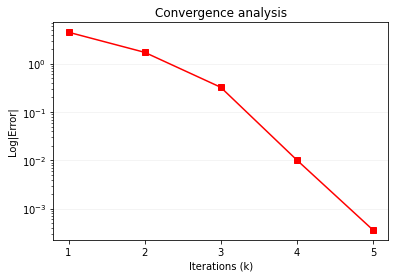

In [10]:
# Initial guess
x = t.tensor([1., 1.], dtype=t.float, requires_grad=True)

# Check if the starting point is valid
val1 , idx1 = t.max(gVals(x), 0)
if val1  > 0:
    sys.exit('Initial guess does not lie in the feasible domain!!!')

# Find the optimal solution using SQP algorithm
print("\nSQP\n")
xSol, fVal, alphaSol, eVal = SQP(x)
print('\nThe optimal solution is x = ', xSol[-1, :])


# Convergence analysis
# Plot results
print("\nConvergence plot\n")
plt.semilogy(range(1, len(fVal)+1), eVal, "rs-")
# plt.xlim(1, 50)
plt.xticks(ticks=range(1, len(fVal)+1), labels=range(1, len(fVal)+1))
plt.xlabel("Iterations (k)")
plt.ylabel("Log|Error|")
plt.title("Convergence analysis")
plt.grid(axis='y', color='0.95')
plt.show()

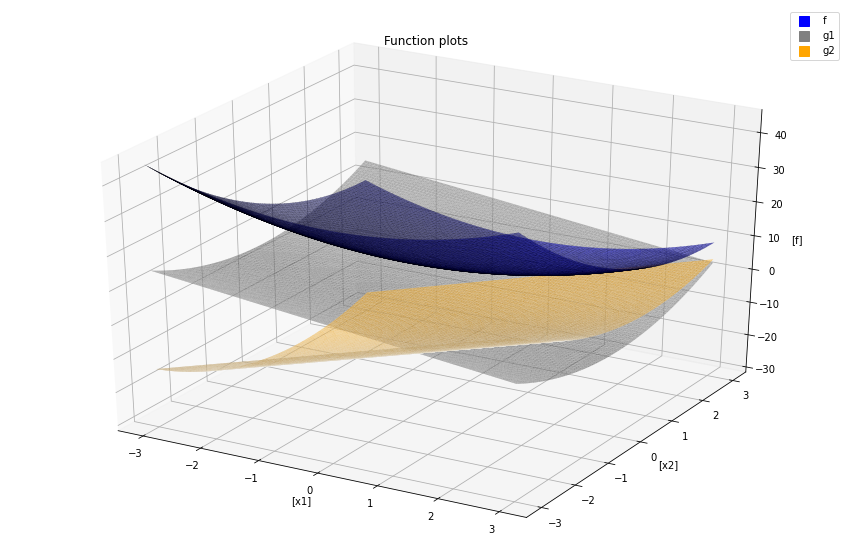

In [8]:
# Grid of points to evaluate the function
x1, x2 = np.mgrid[-3:3:100j, -3:3:100j]
X1 = np.reshape(x1, -1).reshape(-1, 1)
X2 = np.reshape(x2, -1).reshape(-1, 1)
X = np.hstack((X1, X2))

# Evaluate function
fVals, gVal1, gVal2 = f(X.T)

# Plot data
fig1 = plt.figure(figsize=(15,10))
ax1 = fig1.add_subplot(111, projection='3d')

ax1.plot_trisurf(X[:, 0], X[:, 1], fVals.ravel(), edgecolor='black', color='blue', lw=0.05, alpha=0.5, label="Objective function")
ax1.plot_trisurf(X[:, 0], X[:, 1], gVal1.ravel(), edgecolor='white', color='grey', lw=0.05, alpha=0.5, label="Constrain g1")
ax1.plot_trisurf(X[:, 0], X[:, 1], gVal2.ravel(), edgecolor='white', color='orange', lw=0.05, alpha=0.5, label="Constrain g2")
ax1.set_xlabel("[x1]")
ax1.set_ylabel("[x2]")
ax1.set_zlabel("[f]")
ax1.set_title("Function plots")
l1 = mpl.lines.Line2D([0],[0], linestyle="none", c='b', markersize=10, marker = 's')
l2 = mpl.lines.Line2D([1],[0], linestyle="none", c='grey', markersize=10, marker = 's')
l3 = mpl.lines.Line2D([1],[0], linestyle="none", c='orange', markersize=10, marker = 's')
ax1.legend([l1, l2, l3], ['f', 'g1', 'g2'], numpoints = 1)
plt.show()


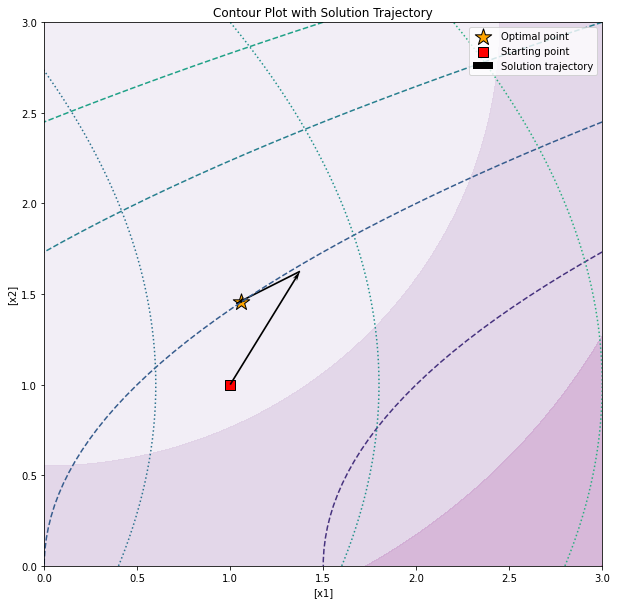

In [9]:
# Display solutions

fig = plt.figure(figsize=(10,10))
plt.contourf(x1, x2, f([x1, x2])[0], linestyles='solid', alpha=0.8, cmap=cm.PuRd)
plt.contour(x1, x2, f([x1, x2])[1], linestyles='dashed')
plt.contour(x1, x2, f([x1, x2])[2], linestyles='dotted')
plt.scatter(xSol[-1, 0], xSol[-1, 1], marker="*", color="orange", edgecolors= "black", s=300, label="Optimal point")
plt.scatter(xSol[0, 0], xSol[0, 1], marker="s", color="red", edgecolors= "black",  s=100, label="Starting point")
plt.quiver(xSol[:-1, 0], xSol[:-1, 1], xSol[1:, 0]-xSol[:-1, 0], xSol[1:, 1]-xSol[:-1, 1], scale_units='xy', angles='xy', scale=1, width=.003, headlength=6, headwidth=3, label='Solution trajectory')
plt.xlabel("[x1]")
plt.ylabel("[x2]")
plt.title("Contour Plot with Solution Trajectory")
plt.xlim(0, 3)
plt.ylim(0, 3)
plt.legend()
plt.show()


---

## Problem 2

Moon lander is characterized by state $ x = [h, v, m]^T $ and action $ \alpha $.


where,

$ h $ - Altitude of the lander

$ v $ - Vertical velocity of the lander

$ m $ - Mass of the lander

$ \alpha $ - Thrust of the lander


The system dynmics are described as:

$$ 
\begin{aligned}
\quad & \dot{h}(t) = v(t) \\
\quad & \dot{v}(t) = -g + \frac{\alpha(t)}{m(t)}\\
\quad & \dot{m}(t) = -K \ \alpha(t) \\
\quad & \alpha \in [0, 1] \\
\end{aligned}
$$


where,

$ K $ - Fuel burning rate

$ g $ - Acceleartion due to gravity

The initial state is $ x_0 = [h_0, v_0, m_0]^T $.

Our objective is to minimize the fuel consumption:

$$ 
\begin{aligned}
\quad & min_{\alpha(t)} P(t) = \int_0^{t^*} \alpha(t) \ dt \\
\quad & h(t^*) = 0 \\
\quad & v(t^*) = 0 \\
\end{aligned}
$$

subject to the system dynamics.

where,

$ t^* $ = Final time value



Formulating an Optimal control problem:

Loss function: $ l = \alpha(t) $

Dynamics: $ f = [v(t), -g + \frac{\alpha(t)}{m(t)}, -K \ \alpha(t)]^T $


Hamiltonian:

$$ 
\begin{aligned}
\quad & H = -l + \lambda^T \ f \\
\quad & H = - \alpha(t) + \lambda_1 \ v(t) + \lambda_2 \ (-g + \frac{\alpha(t)}{m(t)}) + \lambda_3 \ (-K \ \alpha(t))\\
\end{aligned}
$$

where,

$ \lambda = [\lambda_1, \lambda_2, \lambda_3]^T $ - Langrange multipliers

There is no terminal loss in this problem, $ C = 0 $.


To find the optimal control policy $ \alpha^(t)* $, we solve the following equation,

$$ 
\begin{aligned}
\quad & \alpha(t)^* = argmax_{\alpha \in [0, 1]} \ H \\
\quad & \alpha(t)^* = argmax_{\alpha \in [0, 1]} \ \Big((-1 + \frac{\lambda_2}{m(t)} - \lambda_3 \ K) \ \alpha(t) + \lambda_1 \ v(t) - \lambda_2 \ g\Big) \\
\end{aligned}
$$


$$ 
\begin{aligned}
Set, \quad
b = -1 + \frac{\lambda_2}{m(t)} - \lambda_3 \ K 
\end{aligned}
$$


$$ 
\begin{aligned}
\quad & \alpha(t)^* = argmax_{\alpha \in [0, 1]} \ \Big(b \ \alpha(t) + \lambda_1 \ v(t) - \lambda_2 \ g\Big) \\
\end{aligned}
$$


Check if $ b $ is monotonous


We know,

$$ 
\begin{aligned}
\quad & \dot{\lambda} = -\frac{\partial{H}}{\partial{x}} \\
\end{aligned}
$$


$$ 
\begin{aligned}
\begin{bmatrix}
\dot{\lambda_1} \\
\dot{\lambda_2} \\
\dot{\lambda_3} \\
\end{bmatrix}
=
\begin{bmatrix}
- \frac{\partial{H}}{\partial{h}} \\
- \frac{\partial{H}}{\partial{v}} \\
- \frac{\partial{H}}{\partial{m}} \\
\end{bmatrix}
= 
\begin{bmatrix}
0 \\
- \lambda_1 \\
\frac{\lambda_2 \ \alpha}{m(t)^2} \\
\end{bmatrix}
\end{aligned}
$$

Taking time derivative of $ b $

$$ 
\begin{aligned}
\quad & \frac{db}{dt} = \frac{\dot{\lambda_2}}{m(t)} - \frac{\lambda_2 \ \dot{m(t)}}{m(t)^2} - \dot{\lambda_3} \ K \\
\end{aligned}
$$

Substitute values of $ \dot{\lambda} $ and $ \dot{m(t)} $

$$ 
\begin{aligned}
\quad & \frac{db}{dt} = -\frac{\lambda_1}{m(t)} + \frac{\lambda_2 \ \alpha(t) \ K}{m(t)^2} - \frac{\lambda_2 \ \alpha(t) \ K}{m(t)^2}
= 
-\frac{\lambda_1}{m(t)}
\end{aligned}
$$

Since $ \lambda $ and $ m(t) $ are positive quantites, $ b $ is monotonous in nature.

We see that, when $ b $ is monotonous, control policy can be bang-bang

$$
\alpha(t)^* = \begin{cases} 
0 \quad b \le 0 \\
1 \quad b > 0 \\
\end{cases}
$$


So now we can choose a control policy, such that the thrust is zero during the initial descent of the lander  upto time $ t_i $, after which the thrusters are turned on to safely land the vehicle till the terminal time step.

$$
\alpha(t)^* = \begin{cases} 
0 \quad t \in [0, t_i] \\
1 \quad t \in [t_i, t^*] \\
\end{cases}
$$

In the period $ t \in [0, t_i] $

$ f = [v(t), -g + \frac{\alpha(t)}{m(t)}, 0]^T $

In the period $ t \in [t_i, t^*] $

$ f = [v(t), -g + \frac{1}{m(t)}, - K]^T $
